## Importing Libraries

In [122]:
# Importing NumPy for numerical operations
import numpy as np  

# Importing Pandas for data manipulation and analysis
import pandas as pd  

# Importing Matplotlib for plotting
import matplotlib.pyplot as plt  

# Importing Seaborn for statistical data visualization
import seaborn as sns  

# Importing Plotly Express for interactive plotting
import plotly.express as px  

# Importing WordCloud for generating word clouds
from wordcloud import WordCloud  

# Importing warnings module to suppress any warnings
import warnings  
warnings.filterwarnings('ignore')  # Filtering out warnings to maintain clean output

In [123]:
# Importing train_test_split function for splitting data into training and testing sets
from sklearn.model_selection import train_test_split  

# Importing the one_hot function from the tensorflow.keras.preprocessing.text module
from tensorflow.keras.preprocessing.text import one_hot

# Importing pad_sequences function from Keras for padding sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  

# Importing Embedding, LSTM, Dense, Dropout layers from Keras for building neural network
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  

# Importing Sequential model from Keras for building neural network
from tensorflow.keras.models import Sequential  

In [124]:
# Importing NLTK library for natural language processing tasks
import nltk  

# Importing re module for regular expressions
import re  

# Importing stopwords corpus from NLTK for filtering out common words
from nltk.corpus import stopwords  

# Importing PorterStemmer from NLTK for word stemming
from nltk.stem.porter import PorterStemmer  

In [125]:
# Reading a CSV file into a Pandas DataFrame which is our Training Data
train_df = pd.read_csv('train.csv')

In [126]:
# Displaying the first few rows of the DataFrame
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [127]:
# Printing the number of rows and columns in the training set
print('Rows and columns in training set:', train_df.shape)

Rows and columns in training set: (7613, 5)


In [128]:
# Displaying information about the DataFrame, including data types and memory usage
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [129]:
# Generating descriptive statistics of the DataFrame, including measures of central tendency, dispersion, and shape of the distribution
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Exploratory Data Analysis

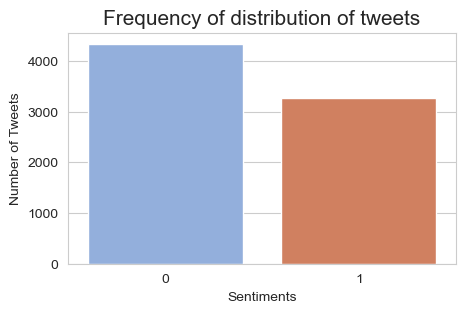

In [130]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (5, 3))
colors = ['#87ace8', '#e3784d']
ax = sns.countplot(x = 'target', data = train_df, palette = colors)
plt.gca().set_ylabel('Number of Tweets')
plt.gca().set_xlabel('Sentiments')
plt.title('Frequency of distribution of tweets', fontsize = 15)
plt.show()

In [131]:
fig = px.pie(train_df, names = 'target', height = 400, width = 400, color_discrete_sequence = colors, title = 'Pie chart for distribution of tweets')
fig.update_traces(textfont_size = 15)
fig.show()

In [132]:
# Counting the occurrences of each unique value in the 'keyword' column in the training dataset and storing it in a new DataFrame
dist_keyword = train_df['keyword'].value_counts()

In [133]:
# Displaying the first few rows of the DataFrame containing the counts of each unique value in the 'keyword' column
dist_keyword.head()

fatalities    45
deluge        42
armageddon    42
sinking       41
damage        41
Name: keyword, dtype: int64

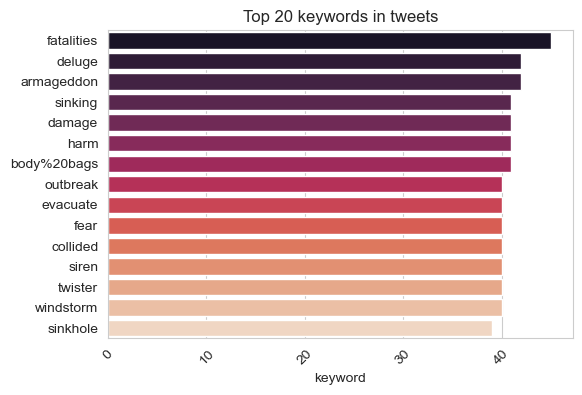

In [134]:
# Setting the style of the seaborn plots to 'whitegrid'
sns.set_style('whitegrid')

# Creating a subplot with a specified size
fig, axes = plt.subplots(figsize = (6, 4))

# Extracting the top 20 keywords and their counts
top_keywords = train_df['keyword'].value_counts()[:15]

# Creating a bar plot to visualize the top 20 keywords
ax = sns.barplot(y = top_keywords.index, x = top_keywords, palette = 'rocket', data = train_df) 

# Setting the title of the plot
plt.title('Top 20 keywords in tweets', fontsize = 12)

# Rotating x-axis labels for better readability
plt.xticks(rotation = 45)

# Displaying the plot
plt.show()

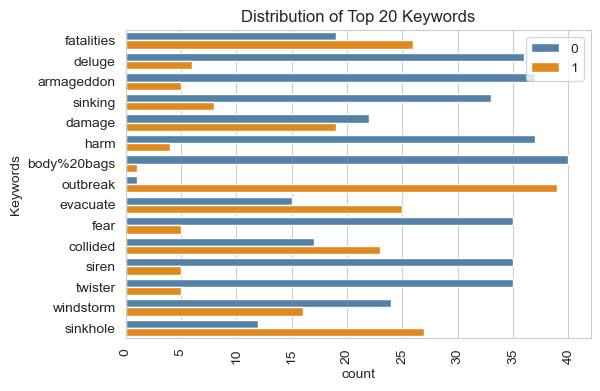

In [135]:
# Creating a new figure with a specified size
plt.figure(figsize = [6, 4])

# Creating a count plot to visualize the distribution of top 20 keywords, differentiated by target
sns.countplot(
    y = 'keyword', data = train_df, 
    order = train_df['keyword'].value_counts()[:15].index, hue = 'target', 
    palette = ['steelblue', 'darkorange']
).set(title = 'Distribution of Top 20 Keywords', ylabel = 'Keywords')

# Rotating x-axis labels for better readability
plt.xticks(rotation = 90)

# Adding a legend to the plot
plt.legend(loc = 'upper right')

# Displaying the plot
plt.show()

In [136]:
# Extracting the counts of disaster-related keywords where target is 1
disaster_keywords = train_df.loc[train_df['target'] == 1]['keyword'].value_counts() 

# Extracting the counts of non-disaster-related keywords where target is 0
non_disaster_keywords = train_df.loc[train_df['target'] == 0]['keyword'].value_counts()

### Plotting Top 20 Disaster and Non-Disaster Keywords

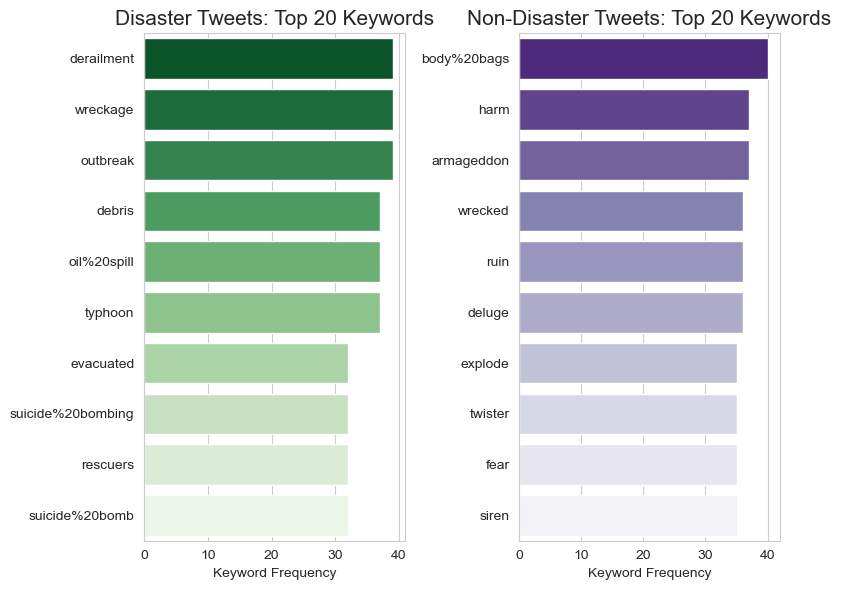

In [137]:
# Creating subplots with two horizontal bar plots side by side, each showing the top 20 keywords for disaster and non-disaster tweets
fig, ax = plt.subplots(1, 2, figsize = (8, 6))

# Plotting the top 20 keywords for disaster tweets
ax1 = sns.barplot(y = disaster_keywords[0:10].index, x = disaster_keywords[0:10], orient = 'h', ax = ax[0], palette = 'Greens_r')
ax[0].set_title('Disaster Tweets: Top 20 Keywords', fontsize = 15)
ax[0].set_xlabel('Keyword Frequency')

# Plotting the top 20 keywords for non-disaster tweets
ax2 = sns.barplot(y = non_disaster_keywords[0:10].index, x = non_disaster_keywords[0:10], orient = 'h', ax = ax[1], palette = 'Purples_r')
ax[1].set_title('Non-Disaster Tweets: Top 20 Keywords', fontsize = 15)
ax[1].set_xlabel('Keyword Frequency')


# Adjusting layout for better visualization
plt.tight_layout()

# Displaying the plot
plt.show()

In [138]:
# Calculating the mean target value for each keyword and creating a new column 'target_mean' with the transformed values
train_df['target_mean'] = train_df.groupby('keyword')['target'].transform('mean') 

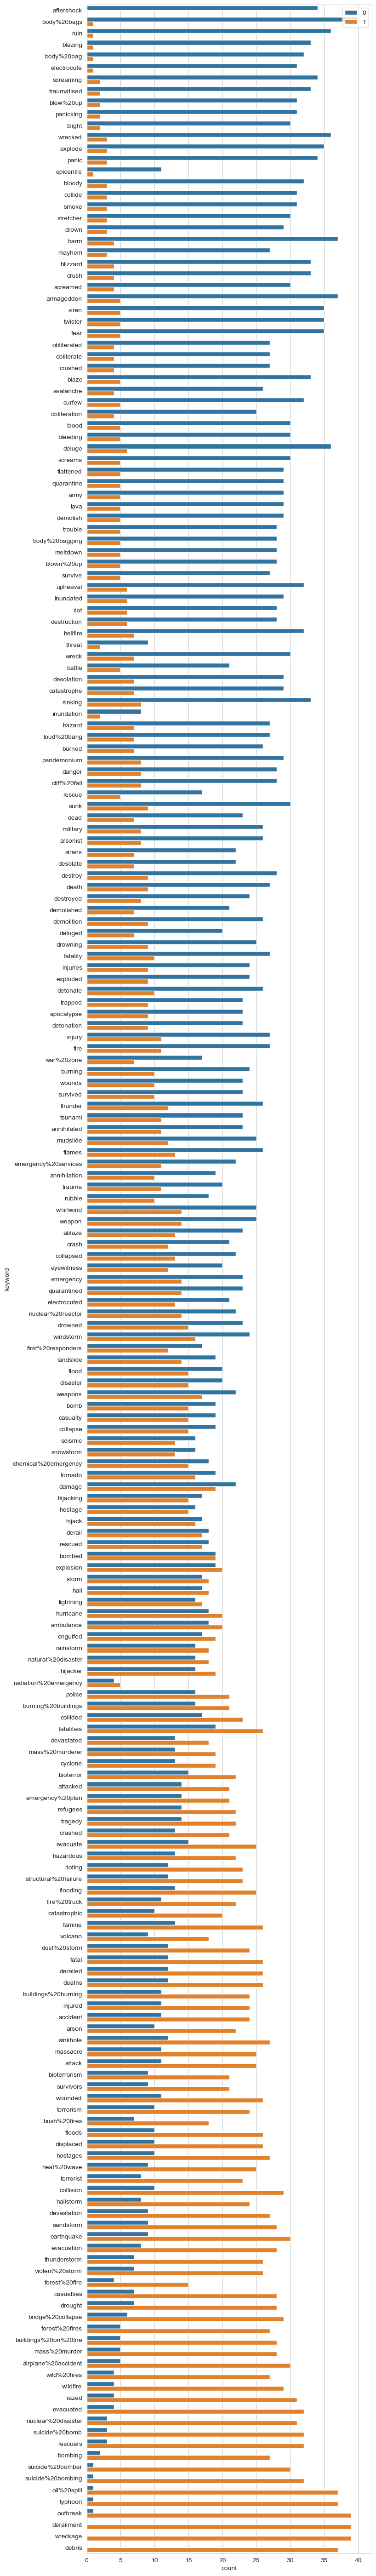

In [139]:
# Creating a figure with a specified size and resolution
plt.figure(figsize = (8, 72), dpi = 100)

# Creating a count plot sorted by the mean target value for each keyword and differentiated by target
sns.countplot(data = train_df.sort_values(by = 'target_mean'), hue = 'target', y = 'keyword')

# Adding a legend to the plot
plt.legend(loc = 1);

In [140]:
# Dropping the 'target_mean' column to clean up the DataFrame
train_df.drop(columns = 'target_mean', inplace = True)

In [141]:
# Creating a new DataFrame containing only rows where the target value is 0 (non-disaster tweets)
fake_df = train_df[train_df['target'] == 0]

In [142]:
# Printing the most common keywords for fake tweets
print('Most common keywords for fake tweets')
fake_df['keyword'].value_counts()[:20]

Most common keywords for fake tweets


body%20bags    40
harm           37
armageddon     37
wrecked        36
ruin           36
deluge         36
explode        35
twister        35
fear           35
siren          35
aftershock     34
panic          34
screaming      34
blizzard       33
blazing        33
blaze          33
crush          33
sinking        33
traumatised    33
curfew         32
Name: keyword, dtype: int64

In [143]:
# Creating a new DataFrame containing only rows where the target value is 1 (disaster tweets)
real_df = train_df[train_df['target'] == 1]

In [144]:
# Printing the most common keywords for real tweets
print('Most common keywords for real tweets')
real_df['keyword'].value_counts()[:20]

Most common keywords for real tweets


derailment               39
wreckage                 39
outbreak                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
suicide%20bombing        32
rescuers                 32
suicide%20bomb           32
nuclear%20disaster       31
razed                    31
suicide%20bomber         30
earthquake               30
airplane%20accident      30
collision                29
wildfire                 29
bridge%20collapse        29
evacuation               28
buildings%20on%20fire    28
Name: keyword, dtype: int64

### Tweets Length

In [145]:
# Calculating the length of each text in the 'text' column and creating a new column 'length' to store the values
train_df['length'] = train_df['text'].apply(len)

In [146]:
# Displaying the first few values of the 'length' column
train_df['length'].head()

0     69
1     38
2    133
3     65
4     88
Name: length, dtype: int64

In [147]:
# Printing the character length of the first tweet
print('Tweet character length for:', train_df['text'][0], 'is', train_df['length'][0])

Tweet character length for: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all is 69


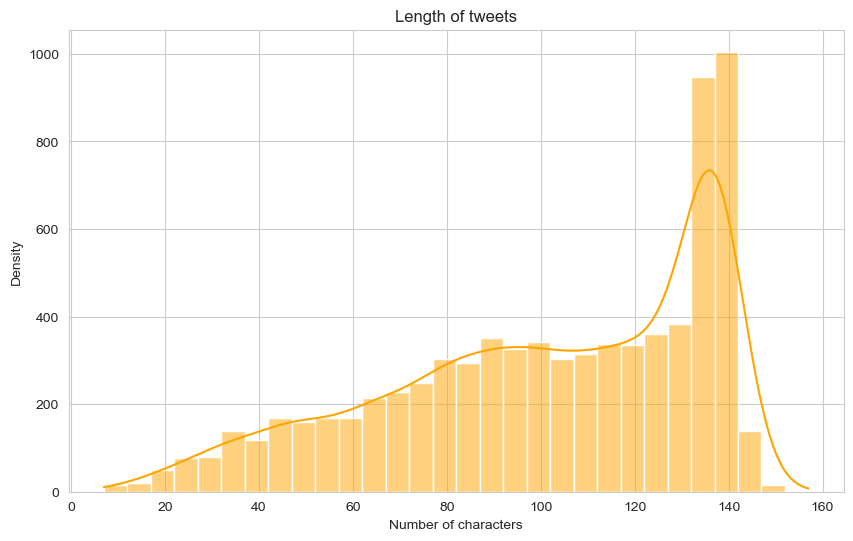

In [148]:
# Creating a histogram to visualize the distribution of tweet lengths
plt.figure(figsize = (10, 6))
sns.histplot(train_df['length'], kde = True, color = 'orange', bins = 30)
plt.title('Length of tweets')
plt.xlabel('Number of characters')
plt.ylabel('Density')
plt.show()

### Tweet length of Disaster/Non-disaster tweets

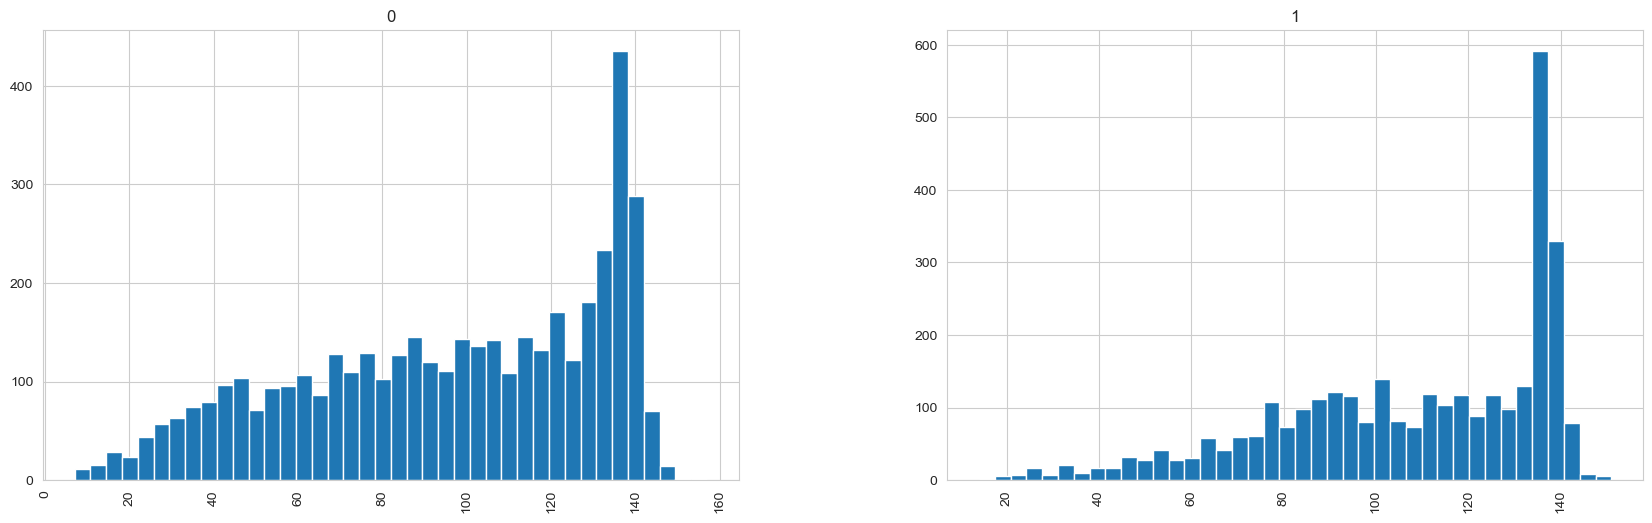

In [149]:
# Creating separate histograms for tweet lengths based on the target value (disaster or non-disaster)
train_df.hist(column = 'length', by = 'target', bins = 40, figsize = (20, 6))
plt.show()

### Top locations from where the tweets were sent

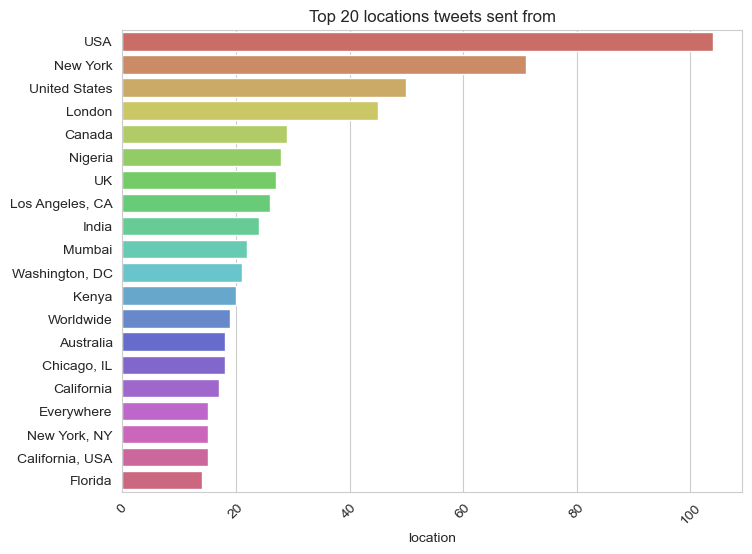

In [150]:
sns.set_style('whitegrid')

# Creating a subplot with a specified size
fig, axes = plt.subplots(figsize = (8, 6))

# Extracting the top 20 locations and their counts
locations = train_df['location'].value_counts()

# Creating a bar plot to visualize the top 20 locations tweets sent from
ax = sns.barplot(y = locations[0:20].index, x = locations[0:20], palette = 'hls', data = train_df)

# Setting the title of the plot
plt.title('Top 20 locations tweets sent from', fontsize = 12)
plt.xticks(rotation = 45)
plt.show()

# **Data Preprocessing**

**Handling null values**

In [151]:
# Counting the number of missing values in each column of the DataFrame
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [152]:
# Calculating the percentage of missing values in each column of the DataFrame
percentage_missing = train_df.isnull().sum() * 100 / len(train_df)

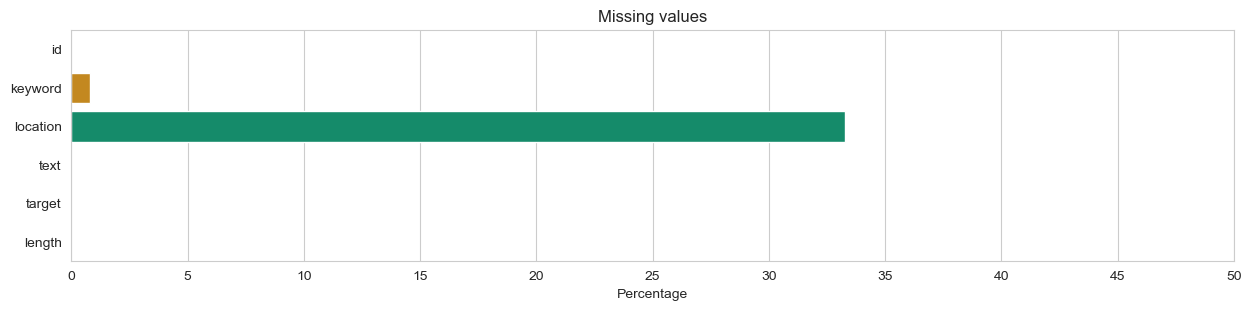

In [153]:
# Creating a bar plot to visualize the percentage of missing values
plt.figure(figsize = (15, 3))
sns.barplot(x = list(percentage_missing), y = list(percentage_missing.index), palette = 'colorblind').set(
    title = 'Missing values',
    xlabel = 'Percentage', xlim = (0, 50), xticks = range(0, 55, 5)
)
plt.show()

In [154]:
# Dropping the 'location' column from the DataFrame
train_df = train_df.drop(['location'], axis = 1)

# Dropping rows with missing values from the DataFrame
train_df = train_df.dropna()

In [155]:
# Checking for missing values after dropping the 'location' column and rows with missing values
train_df.isna().sum()

id         0
keyword    0
text       0
target     0
length     0
dtype: int64

In [156]:
# Displaying the first few rows of the DataFrame after preprocessing
train_df.head()

,id,keyword,text,target,length
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,52,ablaze,Crying out for more! Set me ablaze,0,34
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [157]:
# Resetting the index of the DataFrame after preprocessing
train_df.reset_index(inplace = True)

In [158]:
# Displaying the first few rows of the DataFrame after preprocessing
train_df.head()

,index,id,keyword,text,target,length
0,31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
1,32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,67
2,33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
3,34,52,ablaze,Crying out for more! Set me ablaze,0,34
4,35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [159]:
# Extracting the features (text) and the target variable (target) from the DataFrame
x = train_df['text']
y = train_df['target']

# Printing the shape of the target variable
y.shape

(7552,)

In [160]:
# Downloading the stopwords corpus from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mawat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

result.lower
- By this we are going to replace all the words in Lower case so that all are treated as equally

re.sub()
- Replace with regular expression
- Replace multiple substrings with the same string
- Replace using the matched part
- Get the count of replaced parts
- Here we are going to replace all regural expression which are not between a to z or A to Z with whitespace.

ps.stem()
- Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.
- A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”

In [161]:
# Initializing PorterStemmer from NLTK
ps = PorterStemmer()

# Initializing an empty list to store the preprocessed text
corpus = []

# Iterating through each text in the DataFrame
for i in range(0, len(train_df)):
    # Removing non-alphabetic characters and converting text to lowercase
    review = re.sub('[^a-zA-Z]', ' ', train_df['text'][i])
    review = review.lower()
    
    # Tokenizing the text
    review = review.split()
    
    # Stemming each word in the text and removing stopwords
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    
    # Joining the stemmed words back into sentences
    review = ' '.join(review)
    
    # Appending the preprocessed text to the corpus list
    corpus.append(review)

In [162]:
# Displaying the first 10 preprocessed texts
corpus[:10]

['bbcmtd wholesal market ablaz http co lhyxeohi c',
 'alway tri bring heavi metal rt http co yao e xngw',
 'africanbaz break news nigeria flag set ablaz aba http co nndbgwyei',
 'cri set ablaz',
 'plu side look sky last night ablaz http co qqsmshaj n',
 'phdsquar mufc built much hype around new acquisit doubt set epl ablaz season',
 'inec offic abia set ablaz http co imaomknna',
 'barbado bridgetown jamaica two car set ablaz santa cruz head st elizabeth polic superintend http co wdueaj q j',
 'ablaz lord',
 'check http co roi nsmejj http co tj zjin http co yduixefip http co lxtjc kl nsfw']

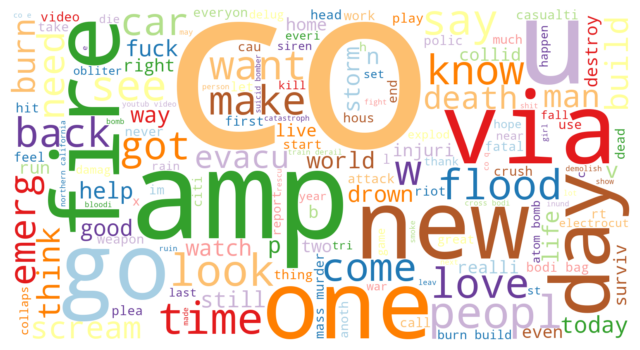

In [167]:
# Generating a word cloud from the corpus
wordcloud = WordCloud(
    background_color = 'white', 
    max_words = 150, width = 1500, height = 800, 
    colormap = 'Paired'
).generate(''.join(corpus))

# Creating a figure with a specified size
plt.figure(figsize = (8, 6))

# Displaying the word cloud
plt.imshow(wordcloud, interpolation = 'bilinear')

# Removing axis
plt.axis('off')
plt.show()

### One Hot representation

Convert the pre-processed words to one-hot vectors in the range of vocabulary size = 5000. This is done to obtain numerical feature matrix.

In [41]:
# Defining the vocabulary size
voc_size = 5000

# Generating one-hot representations for each text in the corpus
one_hot_rep = [one_hot(words, voc_size) for words in corpus]

# Displaying the first 5 one-hot representations
one_hot_rep[:5]

[[4803, 887, 576, 423, 4321, 2668, 3017, 2328],
 [4790, 2072, 2969, 816, 2479, 3614, 4321, 2668, 1780, 426, 4605],
 [1100, 1322, 1014, 2987, 2045, 4689, 423, 4016, 4321, 2668, 4135],
 [1076, 4689, 423],
 [621, 1013, 3249, 2884, 3498, 695, 423, 4321, 2668, 3264, 4812]]

In [42]:
corpus[0]

'bbcmtd wholesal market ablaz http co lhyxeohi c'

In [43]:
# Displaying the one-hot representation of the first text in the corpus
one_hot_rep[0]

[4803, 887, 576, 423, 4321, 2668, 3017, 2328]

In [44]:
len(one_hot_rep[0])

8

### Embedding Representation

pad_sequences
- The pad_sequences() function in the Keras deep learning library can be used to pad variable length sequences. The default padding value is 0.0, which is suitable for most applications, although this can be changed by specifying the preferred value via the “value” argument.
- By this we are going to make all the sentances in same length.There are 2 types of padding, "Pre" and "Post", pre means it's going to add 0 in front and post means it's goint add 0 in back


In [45]:
# Setting the maximum length of sentences
sentence_length = 25

# Padding the sequences to ensure uniform length
embedded_docs = pad_sequences(one_hot_rep, padding = 'pre', maxlen = sentence_length)

# Printing the padded sequences
print(embedded_docs)

[[   0    0    0 ... 2668 3017 2328]
 [   0    0    0 ... 1780  426 4605]
 [   0    0    0 ... 4321 2668 4135]
 ...
 [   0    0    0 ... 4321 2668 4501]
 [   0    0    0 ... 4321 2668 2837]
 [   0    0    0 ... 2668 4812 3863]]


## Creating Model

In [46]:
# Defining the number of features for the embedding vector
embedding_vector_features = 40

In [47]:
# Creating a Sequential model
model = Sequential()

# Adding an Embedding layer with the specified vocabulary size, embedding vector features, and input length
model.add(Embedding(voc_size, embedding_vector_features, input_length = sentence_length))

# Adding a Dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Adding an LSTM layer with 200 units
model.add(LSTM(200))
model.add(Dropout(0.3))

# Adding a Dense layer with a single unit and sigmoid activation function
model.add(Dense(1, activation = 'sigmoid'))

# Compiling the model with binary_crossentropy loss function and adam optimizer
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Converting the embedded_docs and y into numpy arrays
z = np.array(embedded_docs)
y = np.array(y)

In [49]:
# Displaying the shapes of z and y
display(z.shape, y.shape)

(7552, 25)

(7552,)

In [50]:
# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size = 0.33, random_state = 42)

### Training the model

In [51]:
# Fitting the model to the training data and validating on the testing data
res = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 32)

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6025 - loss: 0.6553 - val_accuracy: 0.7838 - val_loss: 0.4877
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8316 - loss: 0.4021 - val_accuracy: 0.7786 - val_loss: 0.4744
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8783 - loss: 0.3005 - val_accuracy: 0.7830 - val_loss: 0.5085
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9115 - loss: 0.2275 - val_accuracy: 0.7565 - val_loss: 0.5436
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9077 - loss: 0.2304 - val_accuracy: 0.7461 - val_loss: 0.6780
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9488 - loss: 0.1372 - val_accuracy: 0.7477 - val_loss: 0.8191
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9564 - loss: 0.1116 - val_accuracy: 0.7308 - val_loss: 0.8814
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9731 - loss: 0.0830 - val_accu

In [52]:
def plot_learning_curve(history, epochs):
    # Generating a range of epochs
    epoch_range = range(1, epochs + 1)
    
    # Plotting the training and validation accuracy
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    
    # Adding labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc = 'upper left')
    plt.show()

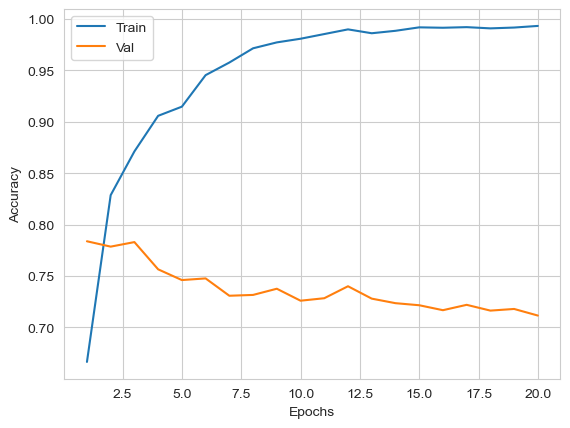

In [53]:
# Plotting the learning curve using the defined function
plot_learning_curve(res, 20)

**Importing test data**

In [54]:
# Reading the test data from the CSV file into a DataFrame
test_df = pd.read_csv('test.csv')

# Displaying the first few rows of the test DataFrame
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [56]:
print('Rows and columns in test dataset:', test_df.shape)

Rows and columns in test dataset: (3263, 4)


In [57]:
test_id = test_df['id'] 
test_df = test_df.drop(['id', 'keyword', 'location'], axis = 1) 
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


**Checking null values**

In [58]:
test_df.isnull().sum()

text    0
dtype: int64

**Data preprocessing test data**

In [59]:
# Initializing PorterStemmer from NLTK
ps = PorterStemmer() 

# Initializing an empty list to store the preprocessed text
corpus_test = []

# Iterating through each text in the test DataFrame
for i in range(0, len(test_df)):
    # Removing non-alphabetic characters and converting text to lowercase
    review = re.sub('[^a-zA-Z]', ' ', test_df['text'][i])
    review = review.lower()
    review = review.split()
    
    # Stemming each word in the text and removing stopwords
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    
    # Joining the stemmed words back into sentences
    review = ' '.join(review)
    
    # Appending the preprocessed text to the corpus list
    corpus_test.append(review)

In [60]:
corpus_test[:5]

['happen terribl car crash',
 'heard earthquak differ citi stay safe everyon',
 'forest fire spot pond gees flee across street cannot save',
 'apocalyps light spokan wildfir',
 'typhoon soudelor kill china taiwan']

In [61]:
one_hot_rep_test = [one_hot(words, voc_size) for words in corpus_test]

**Embedding Representation**

In [62]:
sentence_length = 25

embedded_docs_test = pad_sequences(one_hot_rep_test, padding = 'pre', maxlen = sentence_length)
print(embedded_docs_test)

[[   0    0    0 ... 4577 1784 4155]
 [   0    0    0 ... 4337  436 2806]
 [   0    0    0 ... 2906 4773 2323]
 ...
 [   0    0    0 ... 4321 2668 3998]
 [   0    0    0 ... 2668 2670 1539]
 [   0    0    0 ... 3217 1797 2753]]


In [63]:
# Converting the embedded_docs_test into a numpy array
x_test = np.array(embedded_docs_test) 
x_test

array([[   0,    0,    0, ..., 4577, 1784, 4155],
       [   0,    0,    0, ..., 4337,  436, 2806],
       [   0,    0,    0, ..., 2906, 4773, 2323],
       ...,
       [   0,    0,    0, ..., 4321, 2668, 3998],
       [   0,    0,    0, ..., 2668, 2670, 1539],
       [   0,    0,    0, ..., 3217, 1797, 2753]])

**Making predictions for the test dataset**

In [64]:
check = model.predict(x_test)
check = check.round()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [65]:
val = []
for i in check:
    val.append(i[0])

submission = pd.DataFrame({'id': test_id, 'label': val})
submission.head()

,id,label
0,0,0.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
